# Sentiment Analysis with BERT


## Installations and dependencies


In [ ]:
!pip -q install kaggle transformers tqdm

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import json, os

kaggle_token = {"username":"bottombottle","key":"e1349ce4c676300756fb1f985bc33a46"}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_token, f)

os.chmod('/root/.kaggle/kaggle.json', 0o600)


If saved kaggle json file in drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir -p /root/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json


Downloading dataset from kaggle

In [ ]:
# !mkdir -p /content/data
# !kaggle datasets download -d prakharrathi25/google-play-store-reviews -p /content/data
# !unzip -o "/content/data/google-play-store-reviews.zip" -d /content/data

# !ls /content/data


Dataset URL: https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews
License(s): CC0-1.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 1.08GB/s]
Archive:  /content/data/google-play-store-reviews.zip
  inflating: /content/data/reviews.csv  
google-play-store-reviews.zip  reviews.csv


Uploading dataset to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Google_play_reviews_dataset/"
!cp /content/data/*.csv "/content/drive/MyDrive/Google_play_reviews_dataset/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Google_play_reviews_dataset/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [ ]:
df.shape

(12495, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


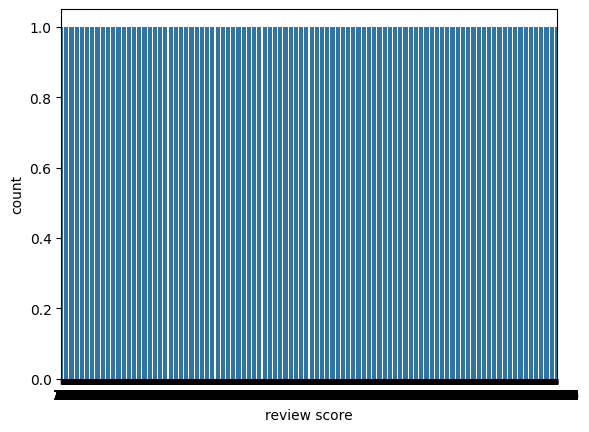

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/tmp/ipython-input-4108417074.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


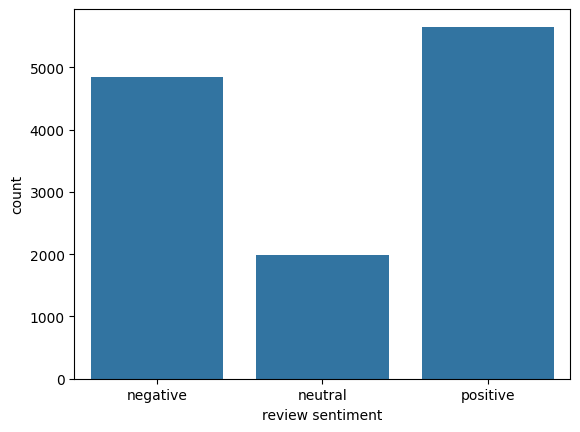

In [ ]:
ax = sns.countplot(x=df['sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)
plt.show()


## Data Preprocessing


- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

### BERT
We are using BERT BASE CASED i.e. Case Sensitive BERT BASE Model with 12 Transformer Encoders stacked .



In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Special Tokens

`[SEP]` - marker for ending of a sentence


`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

There is also a special token for padding:

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
sample_txt = "This app is amazing! I really love using it."


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,  #RETURNS 0 FOR PADDINGS
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'pad_to_max_length': True} not recognized.


KeysView({'input_ids': tensor([[  101,  1188, 12647,  1110,  6929,   106,   146,  1541,  1567,  1606,
          1122,   119,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])})

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

13


tensor([  101,  1188, 12647,  1110,  6929,   106,   146,  1541,  1567,  1606,
         1122,   119,   102])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

13


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'This',
 'app',
 'is',
 'amazing',
 '!',
 'I',
 'really',
 'love',
 'using',
 'it',
 '.',
 '[SEP]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length.

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/tmp/ipython-input-1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


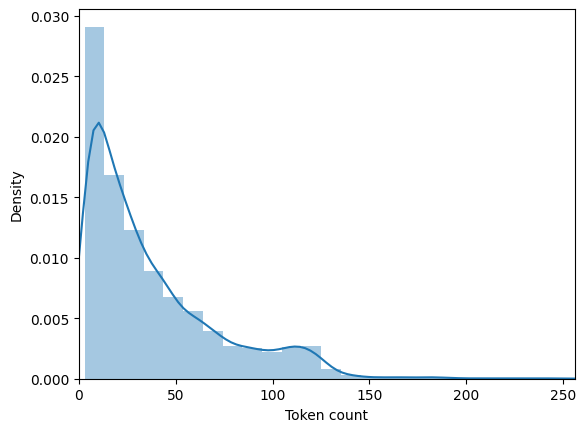

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

In [ ]:
# class GPReviewDataset(Dataset):

#   def __init__(self, reviews, targets, tokenizer, max_len):
#     self.reviews = reviews
#     self.targets = targets
#     self.tokenizer = tokenizer
#     self.max_len = max_len

#   def __len__(self):
#     return len(self.reviews)

#   def __getitem__(self, item):
#     review = str(self.reviews[item])
#     target = self.targets[item]

#     encoding = self.tokenizer.encode_plus(
#       review,
#       add_special_tokens=True,
#       max_length=self.max_len,
#       return_token_type_ids=False,
#       pad_to_max_length=True,
#       return_attention_mask=True,
#       return_tensors='pt',
#     )

#     return {
#       'review_text': review,
#       'input_ids': encoding['input_ids'].flatten(),
#       'attention_mask': encoding['attention_mask'].flatten(),
#       'targets': torch.tensor(target, dtype=torch.long)
#     }


class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',      # ✅ instead of pad_to_max_length=True
      truncation=True,           # ✅ ensure we cut longer texts
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
RANDOM_SEED = 42


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11245, 13), (625, 13), (625, 13))

We also need to create a couple of data loaders.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
outputs = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

last_hidden_state = outputs.last_hidden_state      # or outputs["last_hidden_state"]
pooled_output     = outputs.pooler_output          # or outputs["pooler_output"]

print(last_hidden_state.shape)  # e.g. torch.Size([1, 32, 768])
print(pooled_output.shape)      # e.g. torch.Size([1, 768])

torch.Size([1, 13, 768])
torch.Size([1, 768])


The `last_hidden_state` is a sequence of hidden states of the last layer of the model.

In [ ]:
last_hidden_state.shape

torch.Size([1, 13, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence).

In [ ]:
bert_model.config.hidden_size

768

This is the number of hidden units in the feedforward-networks


`Pooled_output` is a summary of the content, according to BERT.

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
# class SentimentClassifier(nn.Module):

#   def __init__(self, n_classes):
#     super(SentimentClassifier, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.drop = nn.Dropout(p=0.3)
#     self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

#   def forward(self, input_ids, attention_mask):
#     _, pooled_output = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     output = self.drop(pooled_output)
#     return self.out(output)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, model_name=PRE_TRAINED_MODEL_NAME):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)  # return_dict=True by default
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # use the pooled CLS embedding
        pooled_output = outputs.pooler_output     # <--- key line

        output = self.drop(pooled_output)
        return self.out(output)


Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

Create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3745, 0.3734, 0.2521],
        [0.3836, 0.2829, 0.3335],
        [0.2637, 0.2998, 0.4364],
        [0.3174, 0.3057, 0.3769],
        [0.4842, 0.2467, 0.2691],
        [0.3476, 0.3827, 0.2698],
        [0.3339, 0.4365, 0.2296],
        [0.2961, 0.2867, 0.4172],
        [0.4669, 0.3499, 0.1832],
        [0.5545, 0.2469, 0.1986],
        [0.2716, 0.5710, 0.1574],
        [0.2735, 0.2951, 0.4314],
        [0.2826, 0.4731, 0.2443],
        [0.2739, 0.5163, 0.2098],
        [0.3381, 0.2027, 0.4592],
        [0.5208, 0.2351, 0.2441]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

We'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).



In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5630327442801355 accuracy 0.7834593152512228
Val   loss 0.6277043711394071 accuracy 0.768

Epoch 2/10
----------
Train loss 0.43600937423917596 accuracy 0.8343263672743442
Val   loss 0.7123193312436342 accuracy 0.752

Epoch 3/10
----------
Train loss 0.3271974053049717 accuracy 0.8841262783459316
Val   loss 0.8249633299186826 accuracy 0.7392000000000001

Epoch 4/10
----------


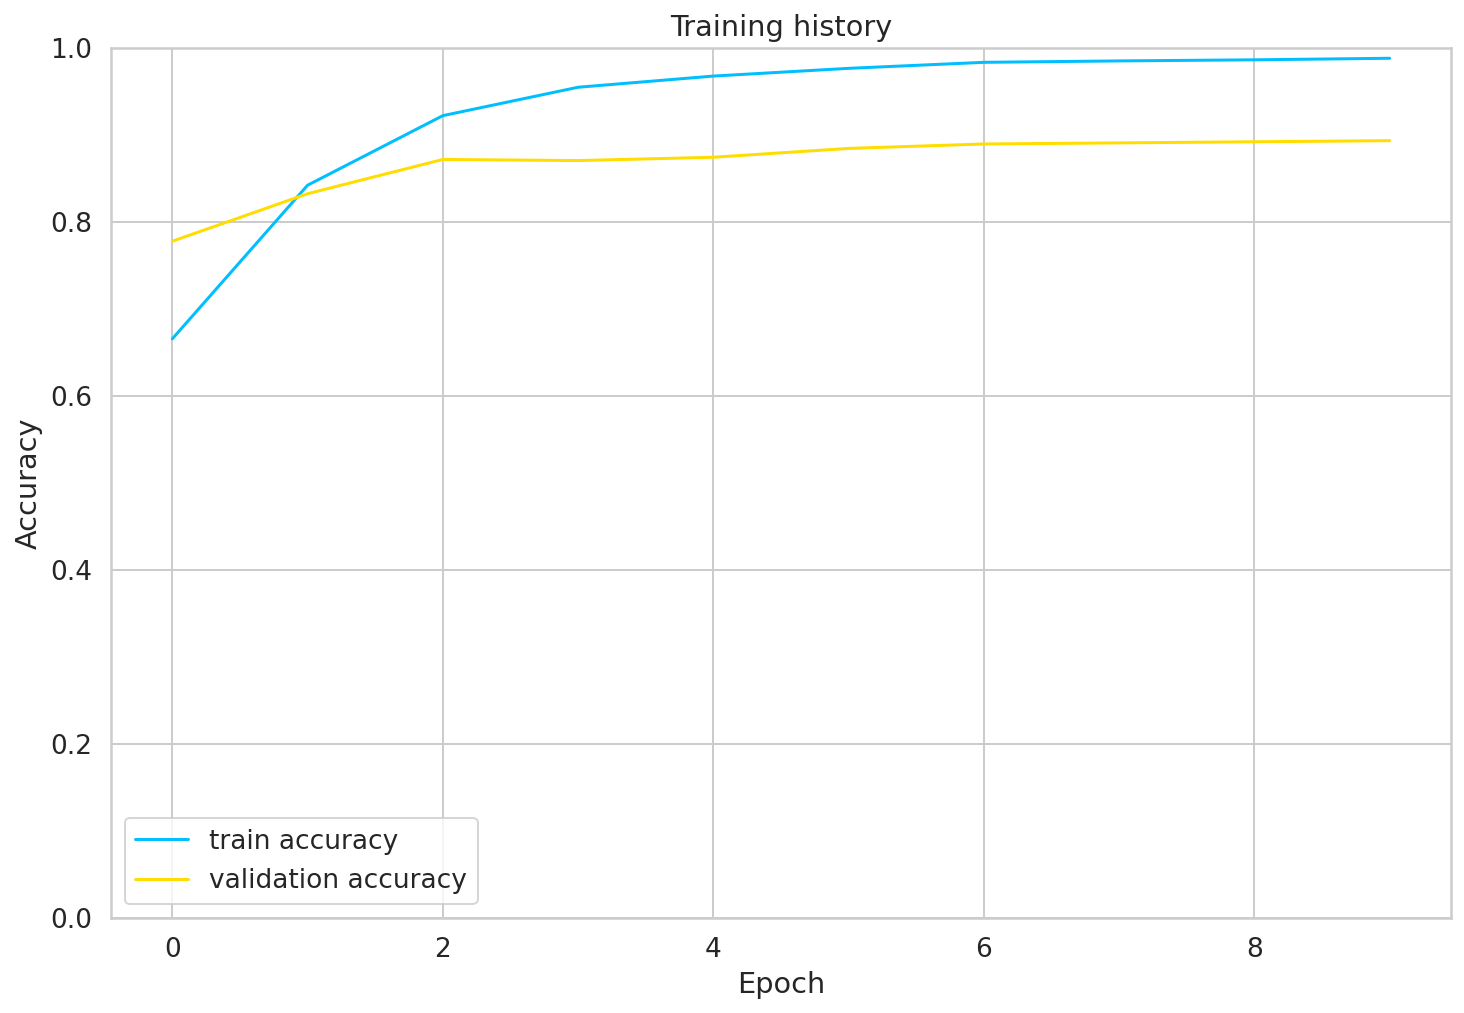

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation



In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.883248730964467

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



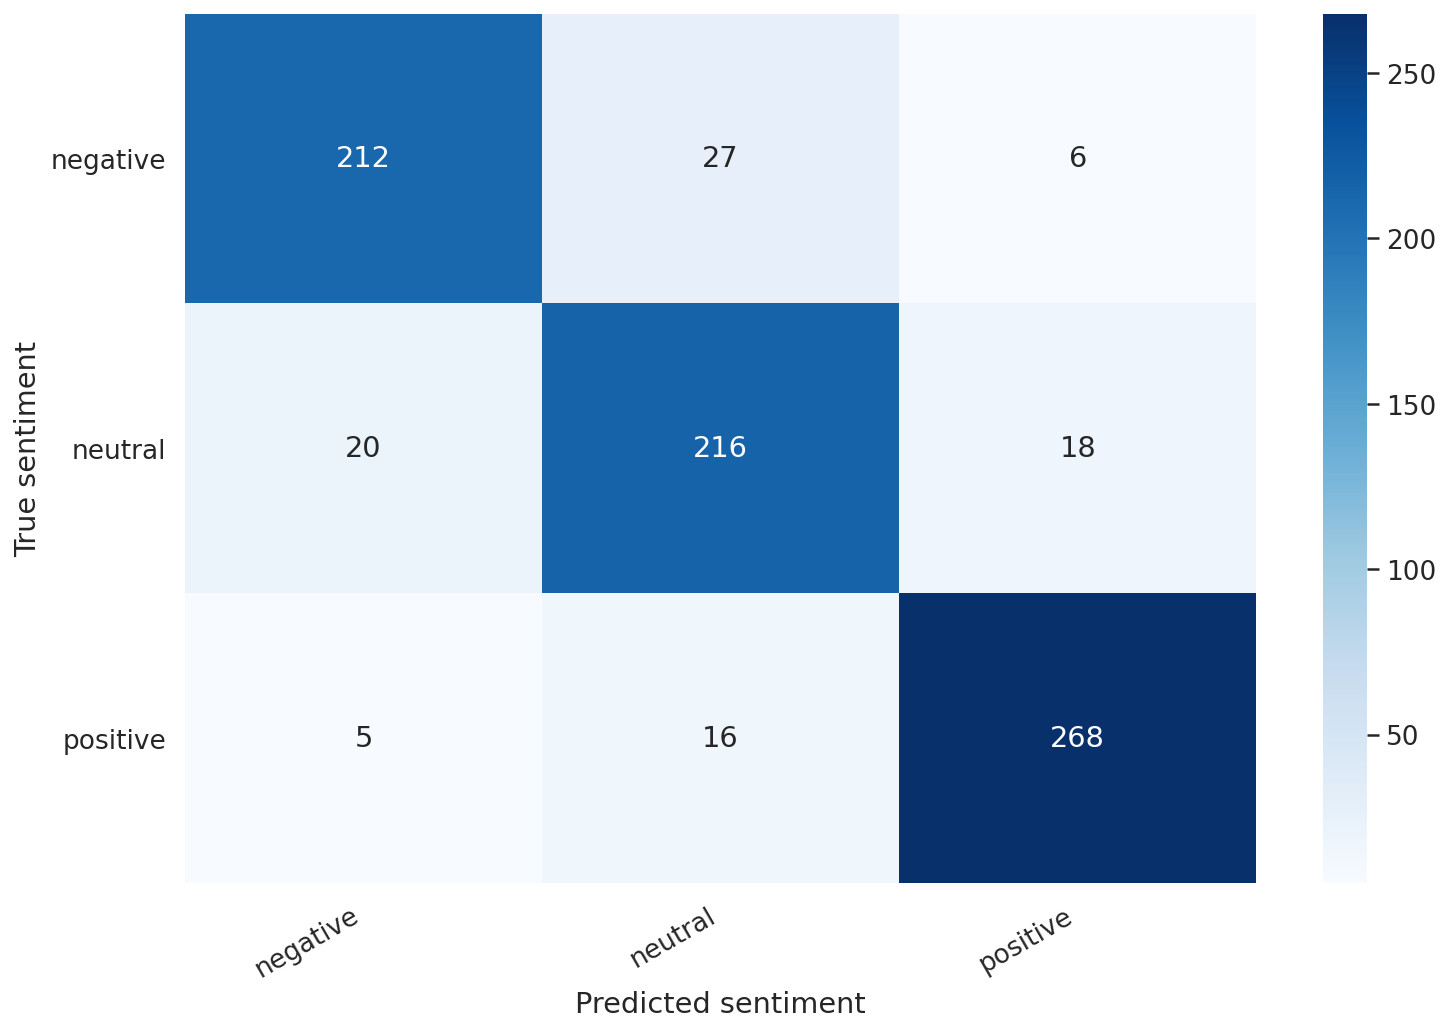

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model.

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

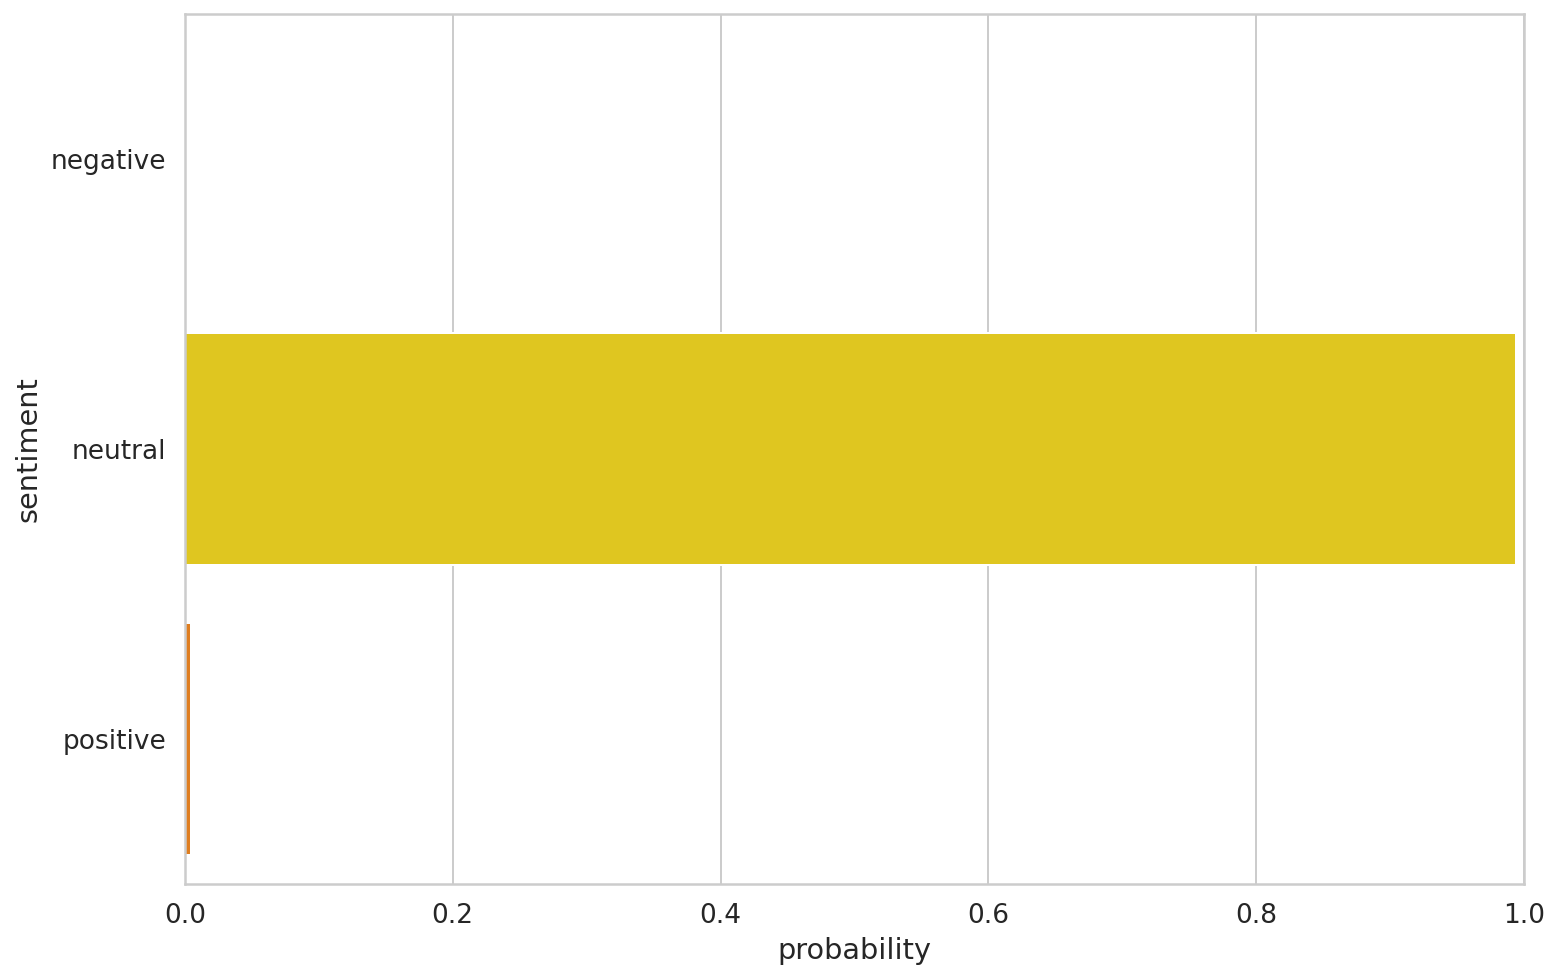

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
